In [2]:
import scanpy as sc
import scvi
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import numpy.random
import pingouin as pg
import anndata
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [68]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
kbet = importr('kBET')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
adni_all = pd.read_csv("/home/fengling/Documents/nnbatch/data/raw/ADNI_ANTsSST_protocol_2019_03_14.csv")

adni_all["site"] = adni_all["site"].astype("category")

#adni_all = adni_all.loc[adni_all.VISIT == 0]

adni_x = adni_all.iloc[:, 42:].reset_index(drop = True)

adni_obsm = adni_all.iloc[:, 0:42].reset_index(drop = True)

adata = sc.AnnData(X = adni_x,
                   obs = adni_obsm)

adata.layers["raw"] = adata.X.copy()

adata.layers["scaled"] = np.round(adata.X.copy() * 1000000)

/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
def plot_pca_umap(adata, layer_key: str, umap_min_dist: float, color: list, 
                  use_rep = False):
    if use_rep:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    pc_num = min([adata_tmp.X.shape[1] - 1, 50])
    sc.tl.pca(adata_tmp, svd_solver='arpack', n_comps = pc_num)
    sc.pp.neighbors(adata_tmp, n_pcs = pc_num, n_neighbors = 10)
    sc.tl.umap(adata_tmp, min_dist = umap_min_dist, maxiter = 500)
    print("UMAP")
    sc.pl.umap(adata_tmp,
           color = color,
           frameon = False,)
    print("PCA")
    sc.pl.pca(adata_tmp, 
          color = color,
         frameon = False)

In [84]:
def evaluate_batch_effect(adata, layer_key: str, batch_key: str, 
                          shuffle_y = False, verbose = False, 
                          use_rep = False, skip_kbet = False) -> list:
    if use_rep:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    x = adata_tmp.X.copy()
    y = adata_tmp.obs[batch_key].copy().to_numpy()
    if shuffle_y:
        if verbose:
            print("Calculating metrics under the null for: " + batch_key)
        numpy.random.shuffle(y)
    if verbose:
        print("Calculating metrics for: " + batch_key)
    xy_df = pd.DataFrame(x)
    xy_df[batch_key] = y

    # get random forest OOB for ability to predict batch_key
    rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
    rf_oob = rf.oob_score_
    if verbose:
        print("Random forest OOB: " + str(rf_oob))

    # get ANOVA p-values
    f_stats = []
    for i in range(x.shape[1]):
        f_stats.append(pg.anova(data = xy_df, dv = i, between = batch_key, detailed = True).F[0])
    mean_f_stat = np.mean(f_stats)
    if verbose:
        print("Average ANOVA F-stat: " + str(mean_f_stat))
    
    if skip_kbet:
        metrics = [rf_oob, mean_f_stat]
        return metrics

    # get kBET results
    r_x = ro.conversion.py2rpy(pd.DataFrame(x))
    r_y = ro.conversion.py2rpy(y)
    kbet_out = kbet.kBET(r_x, r_y, plot = False)
    kbet_pval = kbet_out.rx("average.pval")[0][0]
    if verbose:
        print("kBET p-value is: " + str(kbet_pval))
    
    metrics = [rf_oob, mean_f_stat, kbet_pval]
    return metrics

In [85]:
def evaluate_biologic_info(adata, layer_key: str, biologic_key: str, is_categorical = True,
                           shuffle_y = False, verbose = False, use_rep = False,
                          skip_kbet = False):
    if use_rep:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    x = adata_tmp.X.copy()
    y = adata_tmp.obs[biologic_key].copy().to_numpy()
    if shuffle_y:
        if verbose:
            print("Calculating metrics under the null for: " + biologic_key)
        numpy.random.shuffle(y)
    if verbose:
        print("Calculating metrics for: " + biologic_key)
    xy_df = pd.DataFrame(x)
    xy_df[biologic_key] = y
    
    # get random forest OOB for ability to predict batch_key
    if is_categorical:
        rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    else:
        rf = RandomForestRegressor(oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    if verbose:
        print("Random forest OOB: " + str(rf_oob))
    
    # get ANOVA p-values
    f_stats = []
    if is_categorical:
        for i in range(x.shape[1]):
            f_stats.append(pg.anova(data = xy_df, dv = i, between = biologic_key, detailed = True).F[0])
    else:
        for i in range(x.shape[1]):
            f_stats.append(np.absolute(pg.linear_regression(X = xy_df[biologic_key], y = xy_df.iloc[:, i])["T"][1]))
        r2 = pg.linear_regression(X = xy_df.iloc[:, 1:x.shape[1]], y = xy_df[biologic_key])["r2"][0]
    mean_f_stat = np.mean(f_stats)
    if verbose:
        print("Average ANOVA F-stat: " + str(mean_f_stat))
        if not is_categorical:
            print("R^2 is: " + str(r2))
    
    if skip_kbet or not is_categorical:
        if not is_categorical:
            metrics = [rf_oob, np.mean(f_stats), r2]
        else:
            metrics = [rf_oob, np.mean(f_stats)]
        return metrics

    # get kBET results
    if is_categorical:
        r_x = ro.conversion.py2rpy(pd.DataFrame(x))
        r_y = ro.conversion.py2rpy(y)
        kbet_out = kbet.kBET(r_x, r_y, plot = False)
        kbet_pval = kbet_out.rx("average.pval")[0][0]
        if verbose:
            print("kBET p-value is: " + str(kbet_pval))
    
    metrics = [rf_oob, np.mean(f_stats), kbet_pval]
    return metrics

In [94]:
adata.layers["combat"] = sc.pp.combat(adata, key = "manufac", covariates = ["AGE", "DIAGNOSIS", "SEX"], inplace = False)

In [87]:
metrics_obs = evaluate_batch_effect(adata, "raw", "manufac", verbose = True)
sex_obs = evaluate_biologic_info(adata, "raw", "SEX", is_categorical = True, verbose = True)
diagnosis_obs = evaluate_biologic_info(adata, "raw", "DIAGNOSIS", is_categorical = True, verbose = True)
age_obs = evaluate_biologic_info(adata, "raw", "AGE", is_categorical = False, verbose = True)

Calculating metrics for: manufac
Random forest OOB: 0.9363817097415507
Average ANOVA F-stat: 71.94877756683518
kBET p-value is: 6.738232646086306e-05
Calculating metrics for: SEX
Random forest OOB: 0.9502982107355865
Average ANOVA F-stat: 9.213244028555726
kBET p-value is: 0.01411897514114635
Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.9180914512922466
Average ANOVA F-stat: 88.75727896540633
kBET p-value is: 0.2529734579529572
Calculating metrics for: AGE
Random forest OOB: 0.7377526825517401
Average ANOVA F-stat: 14.568891359881794
R^2 is: 0.3768544073422111


In [88]:
metrics_null = evaluate_batch_effect(adata, "raw", "manufac", shuffle_y = True, verbose = True)
sex_null = evaluate_biologic_info(adata, "raw", "SEX", is_categorical = True, shuffle_y = True, verbose = True)
diagnosis_null = evaluate_biologic_info(adata, "raw", "DIAGNOSIS", is_categorical = True, shuffle_y = True, verbose = True)
age_null = evaluate_biologic_info(adata, "raw", "AGE", is_categorical = False, shuffle_y = True, verbose = True)

Calculating metrics under the null for: manufac
Calculating metrics for: manufac
Random forest OOB: 0.3956262425447316
Average ANOVA F-stat: 1.7591529603234126
Calculating metrics under the null for: SEX
Calculating metrics for: SEX
Random forest OOB: 0.5296222664015905
Average ANOVA F-stat: 0.8065710136098011
kBET p-value is: 0.7787266105221047
Calculating metrics under the null for: DIAGNOSIS
Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.42584493041749505
Average ANOVA F-stat: 1.020135555872362
kBET p-value is: 0.9829977351210257
Calculating metrics under the null for: AGE
Calculating metrics for: AGE
Random forest OOB: -0.1372494877892807
Average ANOVA F-stat: 1.2530182464740347
R^2 is: 0.02542223999942772


In [95]:
metrics_combat = evaluate_batch_effect(adata, "combat", "manufac", verbose = True)
sex_combat = evaluate_biologic_info(adata, "combat", "SEX", is_categorical = True, verbose = True)
diagnosis_combat = evaluate_biologic_info(adata, "combat", "DIAGNOSIS", is_categorical = True, verbose = True)
age_combat = evaluate_biologic_info(adata, "combat", "AGE", is_categorical = False, verbose = True)

Calculating metrics for: manufac
Random forest OOB: 0.9650099403578529
Average ANOVA F-stat: 0.8522904162850263
kBET p-value is: 0.0003986090707710499
Calculating metrics for: SEX
Random forest OOB: 0.957455268389662
Average ANOVA F-stat: 45.28852026916852
kBET p-value is: 0.03360516817409265
Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.9996023856858847
Average ANOVA F-stat: 66820.90827464688
kBET p-value is: 0.9175794771059993
Calculating metrics for: AGE
Random forest OOB: 0.7149960684411198
Average ANOVA F-stat: 1.2908166188960493
R^2 is: 0.06857777719719171


In [90]:
to_view = ["strength", "manufac", "DIAGNOSIS", "AGE"]

UMAP


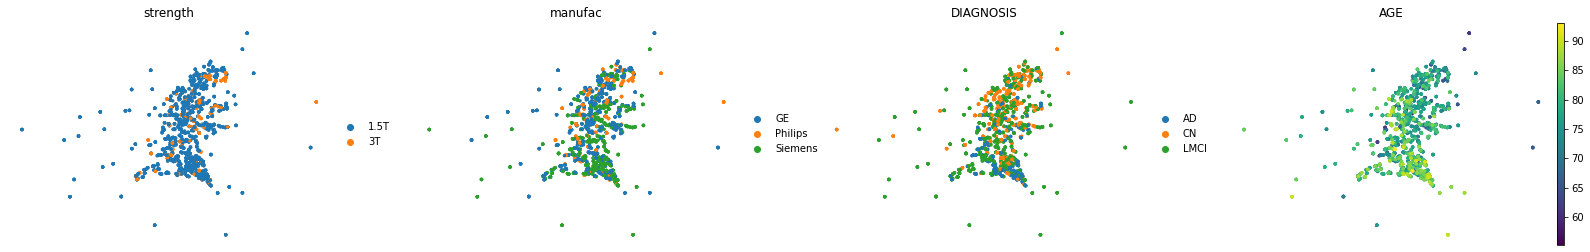

PCA


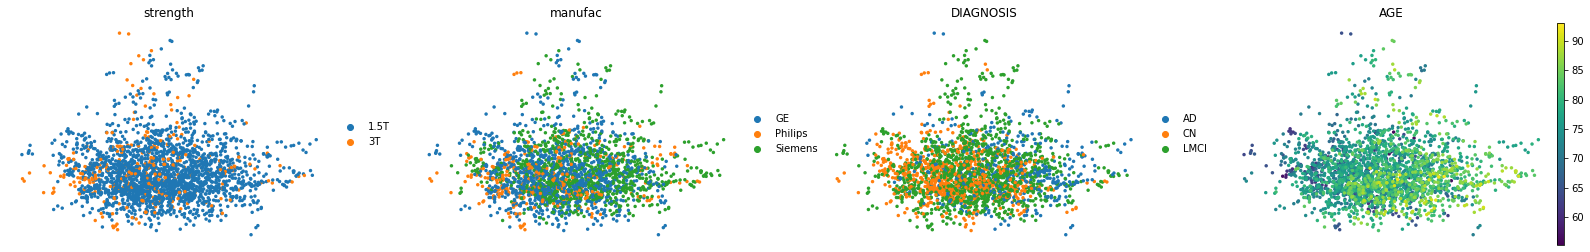

In [92]:
plot_pca_umap(adata, "raw", 0.02, color = to_view)

UMAP


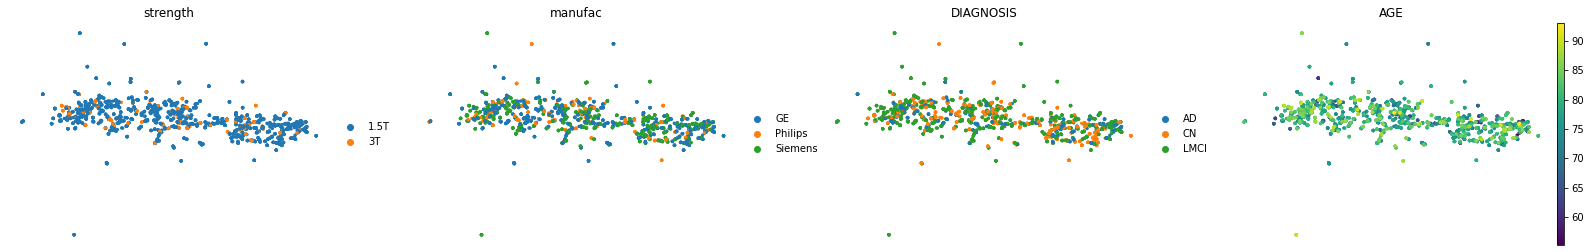

PCA


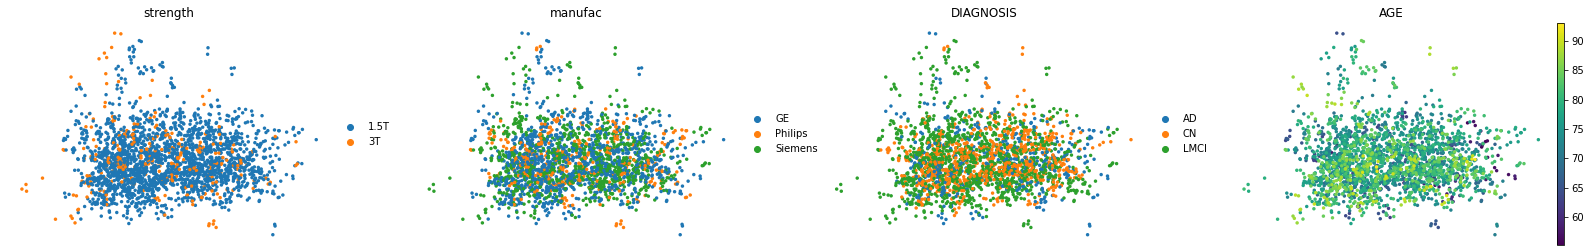

In [93]:
plot_pca_umap(adata, "combat", 0.02, color = to_view)

In [245]:
scvi.model.SCVI.setup_anndata(adata, layer = "scaled", batch_key = "manufac", labels_key = "DIAGNOSIS")
model = scvi.model.SCVI(adata, n_layers = 2, n_latent = 10, gene_likelihood = "nb")
model.train()
model.save("/home/fengling/Documents/nnbatch/code/mod_1")

INFO     Using batches from adata.obs["manufac"]                                             
INFO     Using labels from adata.obs["DIAGNOSIS"]                                            
INFO     Using data from adata.layers["scaled"]                                              
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 3 batches, 3 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|███████| 400/400 [01:04<00:00,  6.18it/s, loss=852, v_num=1]


In [ ]:
model = scvi.model.SCVI.load("/home/fengling/Documents/nnbatch/code/mod_1/", adata)

In [246]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [247]:
metrics_scvi = evaluate_batch_effect(adata, "X_scVI", "manufac", verbose = True, use_rep = True)

Running random forest
Running ANOVAs
Running kBET
[0.8031809145129225, 6.622072703745215, 0.1716792004695058]


UMAP


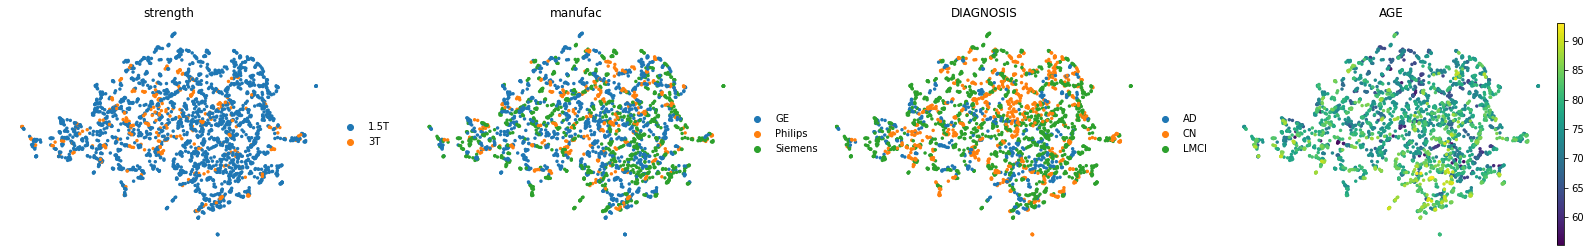

PCA


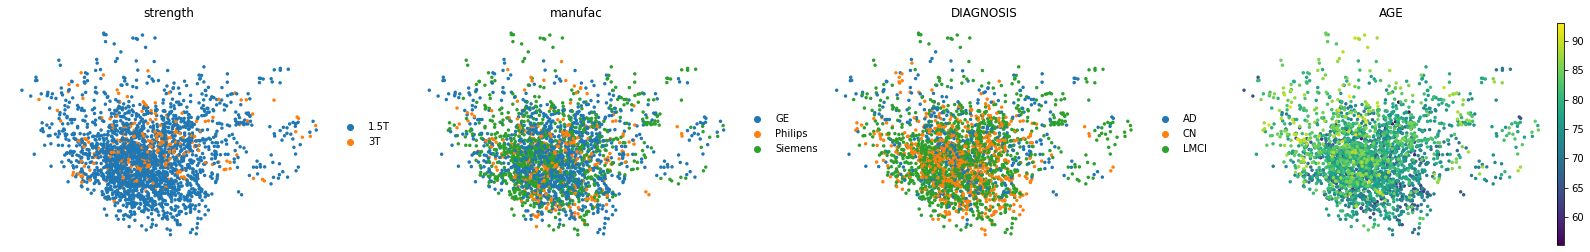

In [250]:
plot_pca_umap(adata, "X_scVI", 0.25, color = to_view, use_rep = True)

In [236]:
min([30, 20])

20